# Heat Wave and Cold Spells

This script processes the dataset "Heat Wave Days" from the Copernicus Climate Data Store. The dataset contains the number of heat wave days (Heat Wave Days; HWD) defined using various European-wide as well as national/regional definitions developed within the framework of the C3S European Health Service. These days are available for different future periods and climate change scenarios.

**Information on Dataset**: 

* Source: [Heat Wave and Cold Spells](https://cds.climate.copernicus.eu/datasets/sis-heat-and-cold-spells?tab=overview)
* Author: T. Tewes (Stadt Konstanz) 
* Notebook-Version: 1.2 (Updated: March 05, 2025)

## 1. Specifying the paths and working directories

In [18]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\sis-heat-and-cold-spells\download"
working_folder = r".\data\sis-heat-and-cold-spells\working"
geotiff_folder = r".\data\sis-heat-and-cold-spells\geotiff"
csv_folder = r".\data\sis-heat-and-cold-spells\csv"
output_folder = r".\data\sis-heat-and-cold-spells\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract the Dataset

### 2.1 Authentication

In [19]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

In [20]:
# Define the bounding box coordinates (WGS84 format)
# The coordinates are in the format: [North, West, South, East]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standard format: [West, South, East, North]

# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Load the shapefile of Konstanz (WGS84 projection) for geographic boundary filtering
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extract the bounding box of the shapefile
de_bounds = de_gdf.total_bounds

# Adjust and buffer the bounding box to create a slightly larger
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Rearrange the coordinates to the format: [North, West, South, East]
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [21]:
# The sis-heat-and-cold-spells dataset allows selection between two variables:
# "Heat wave days" and "Cold spell days".
# Depending on the selected variable, the definition options vary.
# For "heat_wave_days", all definitions are available.
# For "cold_spell_days", only 'country_related' definition is supported.

variable_to_definition_map = {
    'heat_wave_days': ['climatological_related', 'health_related', 'country_related'],
    'cold_spell_days': ['country_related']
}

# Selected variable
selected_variable = 'heat_wave_days'

# Retrieve the appropriate definitions based on the selected variable
selected_definition = variable_to_definition_map.get(selected_variable, [])

# Print the selected definitions and variable
print(f"selected_definition: {selected_definition} \nselected_variable: {selected_variable}")

selected_definition: ['climatological_related', 'health_related', 'country_related'] 
selected_variable: heat_wave_days


In [22]:
# Definition of the dataset and the request parameters
dataset = "sis-heat-and-cold-spells"
request = {
    "variable": selected_variable,
    "definition": selected_definition,
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [23]:
# Execute it to download the dataset:
def main_retrieve():
    dataset_filename = f"{dataset}-{selected_variable}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Call the CDS client only if the dataset has not been downloaded before
        client = main()
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    main_retrieve()

Dataset already downloaded.


### 2.3 Extract the ZIP file(s) in folder(s)

In [24]:
import zipfile

# Define a extract folder to ZIP file same as the working folder
extract_folder = os.path.join(working_folder, f"{selected_variable}")
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
try:
    if not os.listdir(extract_folder):
        dataset_filename = f"{dataset}-{selected_variable}.zip"
        dataset_filepath = os.path.join(download_folder, dataset_filename)
        
        with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
            zip_ref.extractall(extract_folder)
            print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Investigate the Metadata of the NetCDF4 file

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Important</span>: While all datasets are available for download, this notebook focuses on analyzing the following selections:
* selected_variable = 'heat_wave_days'
* selected_definition = 'climatological related'

In [25]:
# Define variable and definition
selected_variable = 'heat_wave_days'
selected_definition = 'climatological_related'

### 3.1 Create a Dataframe of Available NetCDF Files

In [26]:
import re
import pandas as pd
import netCDF4 as nc

def meta(filename):
    # Match the filename against the expected pattern
    match = re.search(r"(?P<ds_variable>\w+?)_(?P<ds_definition>\w+?)_(?P<rcp>rcp\d+?)_(?P<rcp_statistic>mean|stdev)_v(\d+\.\d+)\.", filename)
    
    # Raise an error if the filename doesn't match the expected pattern
    if not match:
        raise ValueError("The given filename does not fit the expected naming scheme")
    
    # Function to extract the variable name from the NetCDF file
    def get_nc_variable():
        with nc.Dataset(os.path.join(extract_folder, filename), 'r') as nc_dataset:
            nc_variable_name = nc_dataset.variables.keys()
            return [*nc_variable_name][0]
    
    # Return metadata as a dictionary
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_variable=match.group('ds_variable'),
        ds_definition=match.group('ds_definition'),
        variable_name=get_nc_variable(),
        rcp=match.group('rcp'),
        rcp_statistic=match.group('rcp_statistic')
    )

# Extract metadata for all NetCDF files in the folder
# The nc_files is a dictionary that contains all the relavent metadata of availabe netcdf4 files
# This dictionary is later used to convert to GeoTiff files
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
df_nc_files = pd.DataFrame.from_dict(nc_files)

# Modify pandas display options
pd.options.display.max_colwidth = 30

# Display the DataFrame without displaying the 'path' column
df_nc_files.loc[:, df_nc_files.columns != 'path']

filename ds_variable ds_definition   variable_name  \
0   HWD_EU_climate_rcp45_mean_...         HWD    EU_climate  HWD_EU_climate   
1   HWD_EU_climate_rcp45_stdev...         HWD    EU_climate  HWD_EU_climate   
2   HWD_EU_climate_rcp85_mean_...         HWD    EU_climate  HWD_EU_climate   
3   HWD_EU_climate_rcp85_stdev...         HWD    EU_climate  HWD_EU_climate   
4   HWD_EU_health_rcp45_mean_v...         HWD     EU_health   HWD_EU_health   
5   HWD_EU_health_rcp45_stdev_...         HWD     EU_health   HWD_EU_health   
6   HWD_EU_health_rcp85_mean_v...         HWD     EU_health   HWD_EU_health   
7   HWD_EU_health_rcp85_stdev_...         HWD     EU_health   HWD_EU_health   
8   HWD_national_rcp45_mean_v1...         HWD      national      HWD_merged   
9   HWD_national_rcp45_stdev_v...         HWD      national      HWD_merged   
10  HWD_national_rcp85_mean_v1...         HWD      national      HWD_merged   
11  HWD_national_rcp85_stdev_v...         HWD      national      HWD_merged   

      rcp rcp_statistic  
0   rcp45          mean  
1   rcp45         stdev  
2   rcp85          mean  
3   rcp85         stdev  
4   rcp45          mean  
5   rcp45         stdev  
6   rcp85          mean  
7   rcp85         stdev  
8   rcp45          mean  
9   rcp45         stdev  
10  rcp85          mean  
11  rcp85         stdev

### 3.2 Print unique Variable name(s) and Available Variables

In [27]:
# Define variable to keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variables in each NetCDF file
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # List all variables in the current dataset
        variables_list = list(nc_dataset.variables.keys())
        
        # Print details of the file and its variables
        print(f"{i + 1:<2} {variable_name:<18}: Available variables: {variables_list}")
    
    # Mark this variable as seen
    seen_variables.add(variable_name)

1  HWD_EU_climate    : Available variables: ['HWD_EU_climate', 'height', 'quantile', 'lat', 'lon', 'time']
5  HWD_EU_health     : Available variables: ['HWD_EU_health', 'height', 'lat', 'lon', 'time']
9  HWD_merged        : Available variables: ['HWD_merged', 'height', 'lat', 'lon', 'time']


In [28]:
# Define variable to keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variable information in each NetCDF file  
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue
    
    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:  
        # Access the primary variable data
        variable_data = nc_dataset[variable_name]  

        # Generate a summary of the primary variable
        summary = {
            "Variable Name": variable_name,
            "Data Type": variable_data.dtype,
            "Shape": variable_data.shape,
            "Variable Info": f"{variable_data.dimensions}",
            "Units": getattr(variable_data, "units", "N/A"),
            "Long Name": getattr(variable_data, "long_name", "N/A"),
        }
    
        # Display dataset summary as a DataFrame for better visualization
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])
        print(f"{i + 1}. Summary of Variable '{variable_name}':")
        display(nc_summary)

    # Add the variable name to the seen set
    seen_variables.add(variable_name)  

    # Limit output
    output_limit = 2  
    if len(seen_variables) >= output_limit:  
        print(f".... (Output truncated to first {output_limit} variables)")
        break

1. Summary of Variable 'HWD_EU_climate':


Description                        Remarks
0  Variable Name                 HWD_EU_climate
1      Data Type                        float32
2          Shape                  (100, 82, 95)
3  Variable Info         ('time', 'lat', 'lon')
4          Units                            day
5      Long Name  Ensemble members average n...

5. Summary of Variable 'HWD_EU_health':


Description                        Remarks
0  Variable Name                  HWD_EU_health
1      Data Type                        float32
2          Shape                  (100, 82, 95)
3  Variable Info         ('time', 'lat', 'lon')
4          Units                            day
5      Long Name  Ensemble members average n...

.... (Output truncated to first 2 variables)


## 4. Export the NetCDF4 files in CSV format

### 4.1 Define a Function to convert NetCDF data to a DataFrame

In [29]:
import xarray as xr

# Function for converting NetCDF data into a Pandas DataFrame
def netcdf_to_dataframe(
    nc_file,
    bounding_box=None):

    # Open the NetCDF Dataset in read mode
    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Access the variable data from the dataset
        variable_data = nc_dataset[nc_file['variable_name']]

        # Ensure latitude and longitude names are correct
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Filter the data based on the bounding box, if provided
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Convert the xarray dataset to a pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        variable_column_name = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        df.rename(columns={nc_file['variable_name']: variable_column_name}, inplace=True)

        # Remove columns that are not neeeded (varies depending on the data set)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        if 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 Create DataFrame and Export as merged CSV file

In [30]:
from tqdm.notebook import tqdm
import textwrap

# Define the variable name for filtering NetCDF files
variable_name = 'HWD_EU_climate'  # Other options: HWD_EU_climate, HWD_EU_health, HWD_merged (for HWD_national), or CDS_national

# Create a folder for storing subset CSV files
subset_csv_folder = os.path.join(csv_folder, f"{variable_name}")
os.makedirs(subset_csv_folder, exist_ok=True)  # Ensure the folder exists

# Define the output CSV filename based on variable name and selected definition
csv_filename = f"{variable_name}_{selected_definition}.csv"
csv_filepath = os.path.join(subset_csv_folder, csv_filename)

# Filter the list of NetCDF files to include only those matching the variable name
nc_files_subset = list(filter(lambda nc_file: nc_file['variable_name'] == variable_name, nc_files))

# Export the NetCDF files as merged CSV file
if not os.path.isfile(csv_filepath):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files_subset)]
    df_merged = pd.concat(dataframes, axis=1)
    df_merged.to_csv(csv_filepath, sep=',', encoding='utf8')
else:
    print(f"File already exists at {csv_filepath}. Skipping export.")
    print("Reading existing CSV file...")
    df_merged = pd.read_csv(csv_filepath).set_index(['time', 'lat', 'lon'])

# Function to wrap long column names for better readability
def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)
    
# Modify pandas display options
pd.options.display.float_format = '{:,.2f}'.format
    
# Display DataFrame
df_wrapped = wrap_column_names(df_merged, width=14)
df_wrapped

File already exists at .\data\sis-heat-and-cold-spells\csv\HWD_EU_climate\HWD_EU_climate_climatological_related.csv. Skipping export.
Reading existing CSV file...


HWD_EU_climate _rcp45_mean  \
time       lat   lon                                 
1986-01-01 47.10 5.70                         0.77   
                 5.80                         0.76   
                 5.90                         0.77   
                 6.00                         0.74   
                 6.10                         0.72   
...                                            ...   
2085-01-01 55.20 14.70                        3.60   
                 14.80                        2.84   
                 14.90                        2.58   
                 15.00                        3.00   
                 15.10                        3.43   

                        HWD_EU_climate _rcp45_stdev  \
time       lat   lon                                  
1986-01-01 47.10 5.70                          1.33   
                 5.80                          1.31   
                 5.90                          1.18   
                 6.00                          0.96   
                 6.10                          0.80   
...                                             ...   
2085-01-01 55.20 14.70                         2.06   
                 14.80                         1.80   
                 14.90                         1.48   
                 15.00                         1.58   
                 15.10                         2.30   

                        HWD_EU_climate _rcp85_mean  \
time       lat   lon                                 
1986-01-01 47.10 5.70                         0.77   
                 5.80                         0.76   
                 5.90                         0.77   
                 6.00                         0.74   
                 6.10                         0.72   
...                                            ...   
2085-01-01 55.20 14.70                        6.99   
                 14.80                        5.61   
                 14.90                        5.11   
                 15.00                        5.66   
                 15.10                        6.42   

                        HWD_EU_climate _rcp85_stdev  
time       lat   lon                                 
1986-01-01 47.10 5.70                          0.95  
                 5.80                          0.96  
                 5.90                          0.89  
                 6.00                          0.72  
                 6.10                          0.63  
...                                             ...  
2085-01-01 55.20 14.70                         2.59  
                 14.80                         2.45  
                 14.90                         2.09  
                 15.00                         1.98  
                 15.10                         2.68  

[779000 rows x 4 columns]

## 5. Export the NetCDF4 files to GeoTIFF

### 5.1 Define a Function to export the NetCDF4 file as GeoTIFF File(s)

In [31]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Parameters:
        nc_file (dict): A dictionary with keys 'path' (file path), 'variable', 'rcp', and 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged GeoTIFF or individual GeoTIFFs (optional).
        output_directory (str): Directory to save the output GeoTIFF files (optional).
    """
     
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
                    
        # Apply geographic filtering if a bounding box is provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extract time variable and convert to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Compute spatial resolution and define raster transformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Determine the time range
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Customise start_year and end_year based on the available time period
            if start_year < min_year:
                print(f"Start year {start_year} is before dataset range. Adjusting to {min_year}.")
            if end_year > max_year:
                print(f"End year {end_year} exceeds dataset range. Adjusting to {max_year}.")

            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)
        else:
            # Default to full dataset range
            start_year = min_year
            end_year = max_year
            
        # Get indices corresponding to selected year range
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1  # Full year (monthly data)
        
        # Extract variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index, start_lat:end_lat, start_lon:end_lon]
        
        if merged:
            # Create a merged GeoTIFF containing all time slices as separate bands
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable}_{selected_definition}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)

            # Define output file path
            output_filename = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}_{start_year}-{end_year}.tif"
            output_filepath = os.path.join(subset_directory_path, output_filename)

            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Write each year slice as a band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            # Export as individual GeoTIFF files
            if output_directory:
                subset_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{selected_variable}_{selected_definition}-individual")
                os.makedirs(subset_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                   desc="Exporting individual GeoTIFF files"):
                # Retrieve the date for the current time slice
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Define output file path
                output_filename = f"{nc_file['variable_name']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}_{dt_full}.tif"
                output_filepath = os.path.join(subset_directory_path, output_filename)

                # Export current time slice as an individual GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Export selected NetCDF4 file(s) to GeoTIFF file(s)

In [32]:
if __name__ == "__main__":
    # Export all NetCDF file as merged GeoTIFF file
    for nc_file in nc_files_subset:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            merged=True
            )

    # Export all NetCDF file as individual GeoTIFF file
    for nc_file in nc_files_subset:
        main_export_geotiff(
            nc_file=nc_file,
            bounding_box=None,
            start_year = 1995,
            end_year = 2000,
            merged = False,
            )
            
    # # Additional case (Advanced filtering)
    # temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    # os.makedirs(temp_folder, exist_ok=True)
    
    # main_export_geotiff(
    #     nc_file=nc_files[0],
    #     bounding_box=bbox_wgs84_konstanz_standard,
    #     start_year=1995,
    #     end_year=2000,
    #     merged=True,
    #     output_directory=temp_folder)

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting individual GeoTIFF files:   0%|          | 0/6 [00:00<?, ?it/s]

## 6. Analysis and Visualization Options

### 6.1 Prepare the data for visualization

In [33]:
# Filter data for the city of Konstanz Region (WGS84 format)
lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# Filter the dataframe with query
filtered_df = (
    df_merged.query(
        "@lat_min <= lat <= @lat_max and @lon_min <= lon <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df, width=15)
df_wrapped.head()

lat  lon  HWD_EU_climate_ rcp45_mean  \
time                                                
1986-01-01 47.60 9.00                        0.69   
1986-01-01 47.60 9.10                        0.68   
1986-01-01 47.60 9.20                        0.66   
1986-01-01 47.70 9.00                        0.67   
1986-01-01 47.70 9.10                        0.67   

            HWD_EU_climate_ rcp45_stdev  HWD_EU_climate_ rcp85_mean  \
time                                                                  
1986-01-01                         1.18                        0.69   
1986-01-01                         1.17                        0.68   
1986-01-01                         1.13                        0.66   
1986-01-01                         1.16                        0.67   
1986-01-01                         1.23                        0.67   

            HWD_EU_climate_ rcp85_stdev  
time                                     
1986-01-01                         0.74  
1986-01-01                         0.76  
1986-01-01                         0.74  
1986-01-01                         0.71  
1986-01-01                         0.81

### 6.2 Filter data and calculate monthly average

In [17]:
# Group by the 'time' index and calculate the mean for each group
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['lat', 'lon'])

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df_average, width=15)
df_wrapped.head()

HWD_EU_climate_ rcp45_mean  HWD_EU_climate_ rcp45_stdev  \
time                                                                  
1986-01-01                        0.67                         1.14   
1987-01-01                        0.79                         1.14   
1988-01-01                        0.92                         1.14   
1989-01-01                        0.93                         1.14   
1990-01-01                        0.95                         1.14   

            HWD_EU_climate_ rcp85_mean  HWD_EU_climate_ rcp85_stdev  
time                                                                 
1986-01-01                        0.67                         0.73  
1987-01-01                        0.79                         0.73  
1988-01-01                        0.92                         0.73  
1989-01-01                        0.93                         0.73  
1990-01-01                        0.95                         0.73

### 6.3 Define a Function to create Line Graph with error

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Helper function to plot mean lines with shaded area."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_line_and_shade(filtered_df_average, variable_name_list):
    # Create the plot
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    y_max_list = []
    y_min_list = []
    for variable_name in variable_name_list:
        # Plot data for rcp45
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
            line_color='#1f77b4',
            fill_color='#aec7e8',
            line_label=f"{variable_name}_rcp45_mean",
            fill_label=f"{variable_name}_rcp45_stdev",
            marker_style=None
        )

        # Plot data for rcp85
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
            line_color='#ff7f0e',
            fill_color='#ffbb78',
            line_label=f"{variable_name}_rcp85_mean",
            fill_label=f"{variable_name}_rcp85_stdev",
            marker_style=None
        )
        
        # Interval
        interval = 1

        # Set the Y-axis range dynamically
        rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - \
                    filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - \
                    filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_min = min(rcp45_min, rcp85_min) - 0.5
        y_min = y_min // interval * interval

        rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + \
                    filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + \
                    filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_max = max(rcp45_max, rcp85_max) + 0.5
        y_max = (y_max + interval) // interval * interval
        
        y_max_list.append(y_max)
        y_min_list.append(y_min)

    ax.set_ylim(min(y_min_list), max(y_max_list))
    
    # Adjust x-ticks for better readability
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)
    
    # Add gridlines
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Customize plot labels and title
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Temperature (°C)', fontsize=14, labelpad=10)
    ax.set_title(
        f"{variable_name}\n(Comparing RCP 4.5 and RCP 8.5 Scenarios)",
        fontsize=14,
        fontweight='bold'
    )
    
    # Add description and source
    plt.figtext(
        0.65,
        -0.075,
        (
            'Description: Total number of Heat Wave Days and Cold Spell Days.\n'
            'Temperature statistics for Europe derived from climate projection.\n'
            'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.8be2c014 (Accessed on 14-10-2024)'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )
    
    # Legend adjustments
    ax.legend(loc='upper left', fontsize=10, frameon=True, title='Scenario', title_fontsize=11)
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

### 6.4 Visualization of Line Graph with error

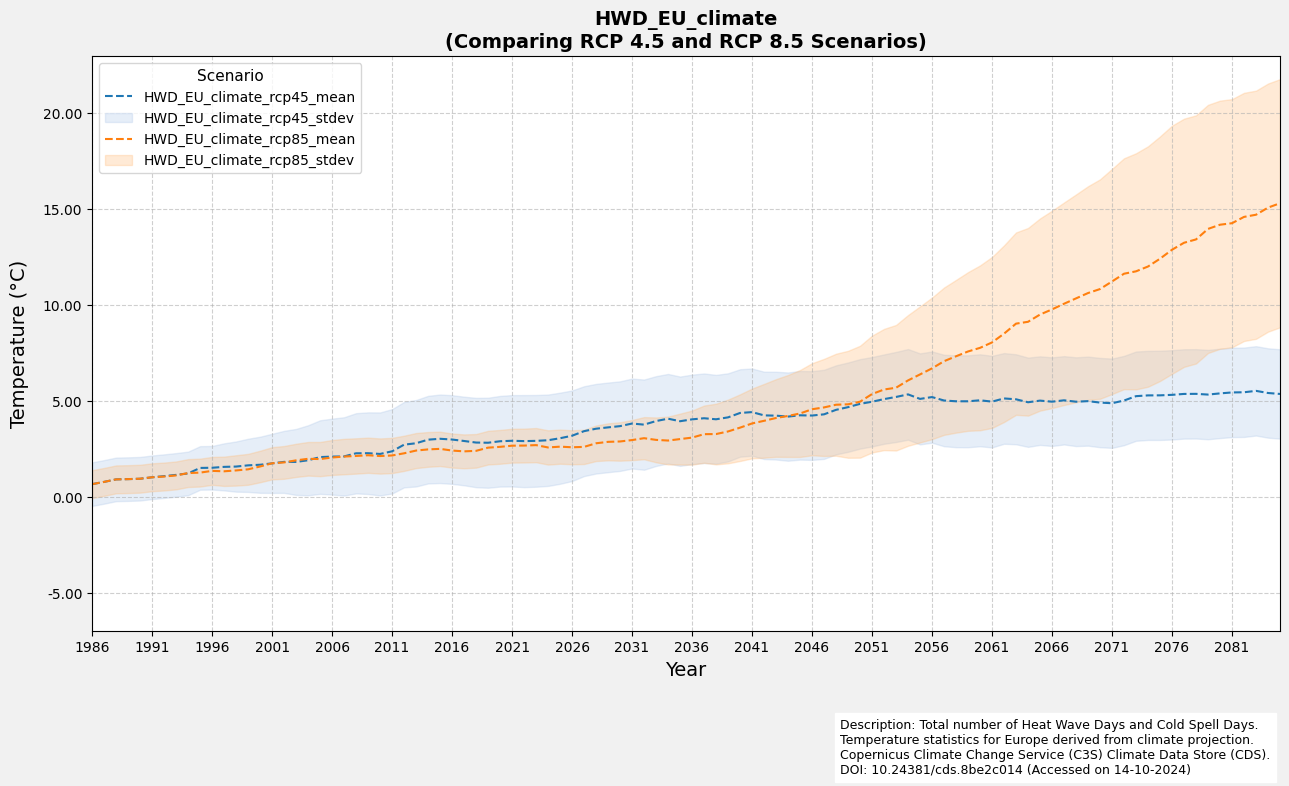

In [19]:
if __name__ == "__main__":
    # Single dataset variable
    # This code fails for Cold Spell Days because of empty data for Konstanz
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                        variable_name_list=[f"{nc_files[0]['variable_name']}"])

### 6.5 Define a Function to create Heatmap

In [34]:
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import numpy as np

def main_plt_plot(
        nc_file=nc_file,
        selected_year=None,
        bounding_box=None):
    
    # Open the NetCDF dataset
    nc_dataset = nc.Dataset(nc_file['path'], mode='r')

    # Access latitude and longitude variables
    lat = nc_dataset.variables['lat'][:]
    lon = nc_dataset.variables['lon'][:]

    # Apply geographic filtering if a bounding box is provided
    if bounding_box:
        lat_indices = np.where((lat >= bounding_box[1]) & (lat <= bounding_box[3]))[0]
        lon_indices = np.where((lon >= bounding_box[0]) & (lon <= bounding_box[2]))[0]

        lat_subset = lat[lat_indices]
        lon_subset = lon[lon_indices]
    else:
        lat_indices = slice(None)
        lon_indices = slice(None)

        lat_subset = lat
        lon_subset = lon

    # Extract variable data
    variable_name = nc_file['variable_name']
    variable_data = nc_dataset.variables[variable_name][..., lat_indices, lon_indices]
    var_units = getattr(nc_dataset.variables[variable_name], "units", "N/A")

    # Determine the year index based on selected_year
    if selected_year < 1986:
        year_index = 0
        year = 1985
    elif selected_year > 2085:
        year_index = -1
        year = 2085
    else:
        year_index = selected_year-1986
        year = selected_year

    # Extract the data for the selected year
    band_data = variable_data[year_index]

    # Remove NaN values for percentile calculations
    band_data_nonan = band_data[~np.isnan(band_data)]
    vmin = np.nanpercentile(band_data_nonan, 1)
    vmax = np.nanpercentile(band_data_nonan, 99)

    def dynamic_round(value):
        # Determine the magnitude of the value
        order_of_magnitude = np.floor(np.log10(abs(value)))
        
        # Use this magnitude to dynamically choose precision
        if order_of_magnitude < -2:  # Values less than 0.01
            return round(value, 3)
        elif order_of_magnitude < -1:  # Values between 0.01 and 1
            return round(value, 2)
        elif order_of_magnitude < 0:  # Values between 1 and 10
            return round(value, 1)
        else:  # Values 10 or larger
            return round(value)
    
    # Apply dynamic rounding to vmin and vmax
    vmin = dynamic_round(vmin)
    vmax = dynamic_round(vmax)

    bins = 10
    interval = (vmax - vmin) / bins
    
    # Create a 2D mesh grid for plotting
    lon_grid, lat_grid = np.meshgrid(lon_subset, lat_subset)

    # Create the figure
    fig, ax = plt.subplots(
        figsize=(12, 8),
        facecolor='#f1f1f1',
        edgecolor='k',
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    # Add map features
    ax.coastlines(edgecolor='black', linewidth=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1.5)

    # Create a colormesh plot with the specified colormap and bounds
    cmap = plt.get_cmap("viridis", bins)
    pcm = ax.pcolormesh(
        lon_grid,
        lat_grid,
        band_data,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        shading='auto',
        vmin=vmin,
        vmax=vmax,
        )
    
    # Add a colorbar
    ticks = np.linspace(vmin, vmax, num=bins + 1)
    cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', pad=0.02, ticks=ticks)
    cbar.set_label(f"{variable_name} ({var_units})", fontsize=12)
    cbar.ax.tick_params(labelsize=12)
    
    # Add grid lines
    gl = ax.gridlines(draw_labels=True,
                      crs=ccrs.PlateCarree(),
                      linewidth=0.8,
                      color='gray',
                      alpha=0.7,
                      linestyle='--')
    gl.top_labels = False 
    gl.right_labels = False
    gl.xlabel_style = {'size': 10, 'color': 'black'}
    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    # Add title and labels
    fig.text(0.5, 0.0, 'Longitude', ha='center', fontsize=14)
    fig.text(0.06, 0.5, 'Latitude', va='center', rotation='vertical', fontsize=14)
    ax.set_aspect("equal")

    # Add a title
    ax.set_title(f"Heat Wave Days ({variable_name}), {year}", fontsize=14)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

### 6.6 Visualization with Heatmap

c:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


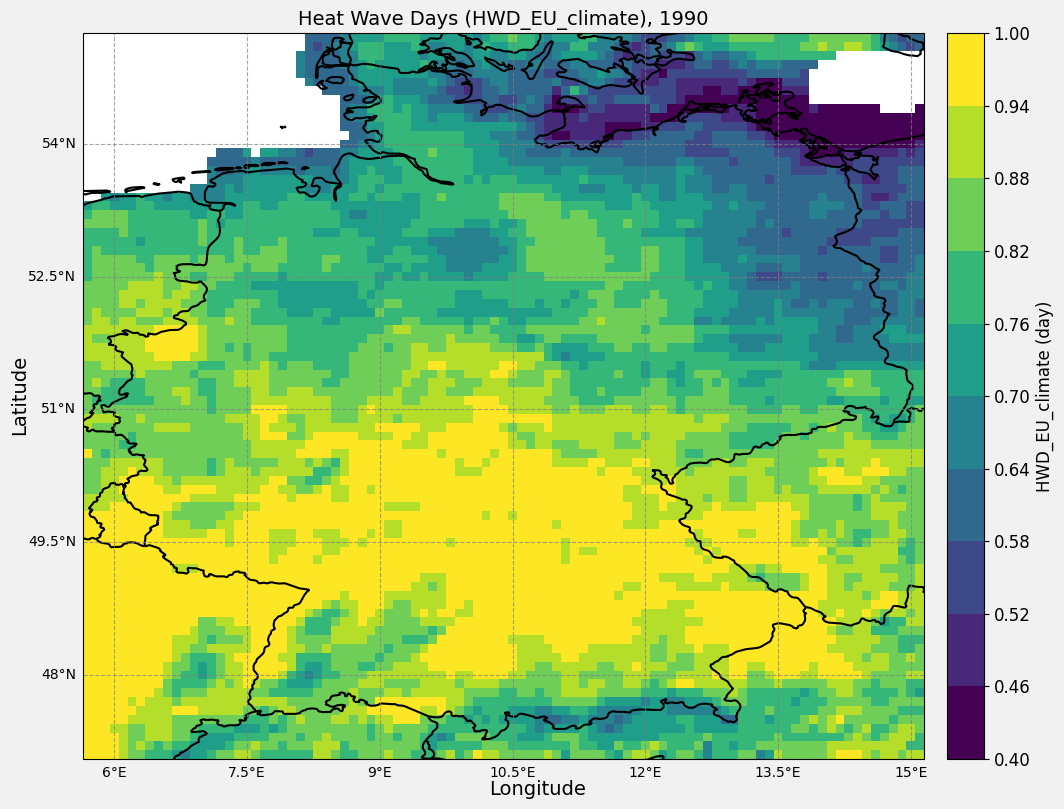

c:\Users\ShaileshShrestha\anaconda3\envs\cds_env\lib\site-packages\numpy\lib\_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


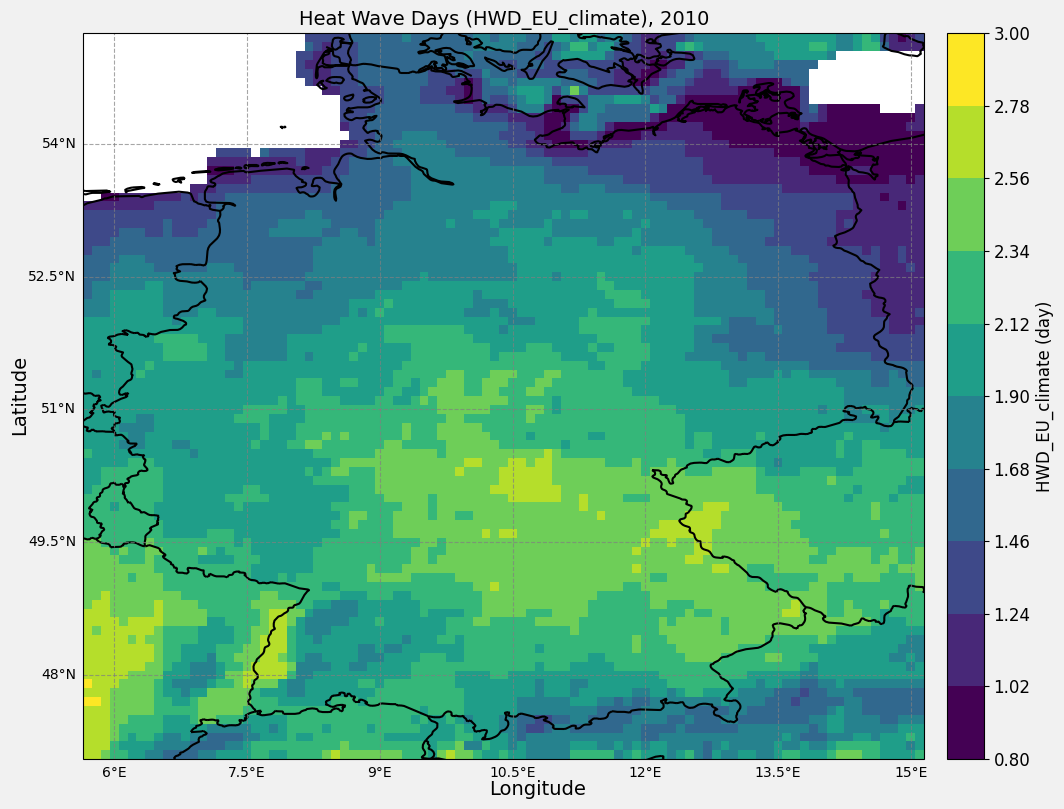

In [36]:
if __name__ == "__main__":
    # Example usage case
    main_plt_plot(nc_file=nc_files[0],
                  selected_year=1990,
                  )

    main_plt_plot(nc_file=nc_files[0],
                  selected_year=2010,
                  )